## Laboratorio 2 - Data Science

Stefano Aragoni, Carol Arévalo

------------------
**Objetivo del laboratorio**: Entrenar una red neuronal convolucional, utilizando la arquitectura Le-Net, para clasificar imágenes de rótulos de tráfico.

------------

### Importar Librerías

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pickle

### Preparación de Datos
1. Descargar el conjunto de datos de rótulos de tráfico que contiene las imágenes de las 43 clases mencionadas.

In [2]:
# Load data from pickle files
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_data = load_data('./Datos_Rotulos_Trafico/entrenamiento.p')
test_data = load_data('./Datos_Rotulos_Trafico/prueba.p')
val_data = load_data('./Datos_Rotulos_Trafico/validacion.p')

In [3]:
train_df = pd.DataFrame({
    'coords': train_data['coords'].tolist(),
    'labels': train_data['labels'].tolist(),
    'features': train_data['features'].tolist(),
    'sizes': train_data['sizes'].tolist()
})

test_df = pd.DataFrame({
    'coords': test_data['coords'].tolist(),
    'labels': test_data['labels'].tolist(),
    'features': test_data['features'].tolist(),
    'sizes': test_data['sizes'].tolist()
})

val_df = pd.DataFrame({
    'coords': val_data['coords'].tolist(),
    'labels': val_data['labels'].tolist(),
    'features': val_data['features'].tolist(),
    'sizes': val_data['sizes'].tolist()
})

(34799, 4)


In [19]:
print("Tamaño train: ", train_df.shape)
print("Tamaño test: ", test_df.shape)
print("Tamaño val: ", val_df.shape)

Tamaño train:  (34799, 4)
Tamaño test:  (12630, 4)
Tamaño val:  (4410, 4)


In [15]:
train_df.head(-5)

,coords,labels,features,sizes
0,"[6, 5, 21, 20]",41,"[[[28, 25, 24], [27, 24, 23], [27, 24, 22], [2...","[26, 25]"
1,"[6, 6, 22, 22]",41,"[[[28, 24, 24], [26, 23, 23], [27, 24, 24], [2...","[27, 27]"
2,"[5, 6, 22, 23]",41,"[[[29, 25, 25], [29, 26, 26], [30, 27, 27], [3...","[27, 28]"
3,"[5, 6, 22, 23]",41,"[[[31, 28, 26], [29, 26, 24], [30, 27, 26], [2...","[27, 28]"
4,"[5, 6, 23, 23]",41,"[[[33, 27, 25], [31, 25, 24], [32, 26, 25], [3...","[29, 29]"
...,...,...,...,...
34784,"[7, 7, 80, 73]",25,"[[[57, 59, 74], [58, 56, 65], [50, 56, 67], [4...","[87, 80]"
34785,"[8, 8, 86, 78]",25,"[[[36, 35, 40], [49, 48, 51], [68, 65, 86], [6...","[94, 85]"
34786,"[8, 7, 88, 78]",25,"[[[39, 38, 46], [37, 37, 46], [58, 59, 59], [8...","[96, 85]"
34787,"[9, 8, 88, 79]",25,"[[[28, 30, 32], [34, 34, 37], [40, 41, 45], [4...","[96, 86]"


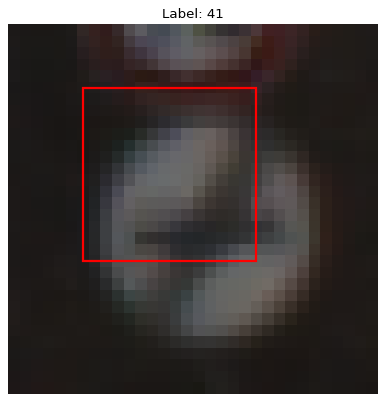

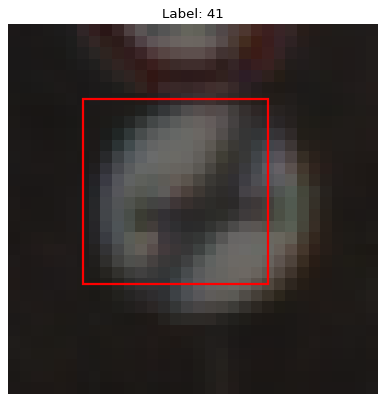

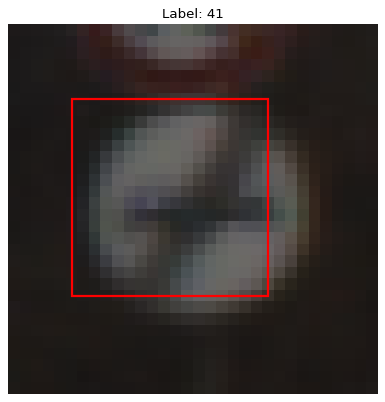

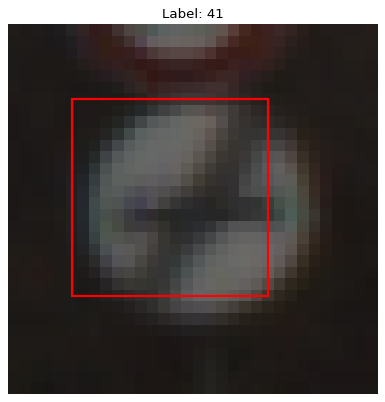

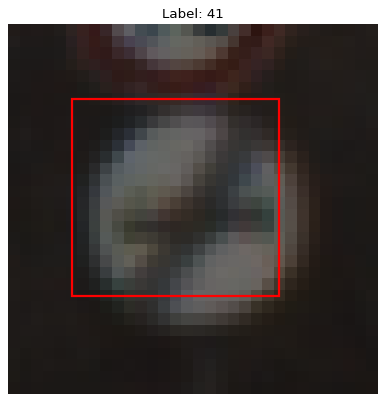

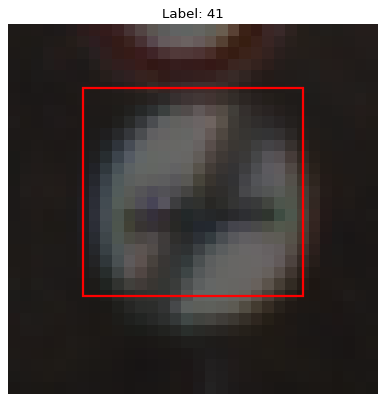

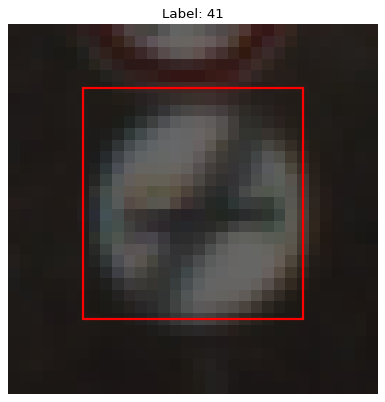

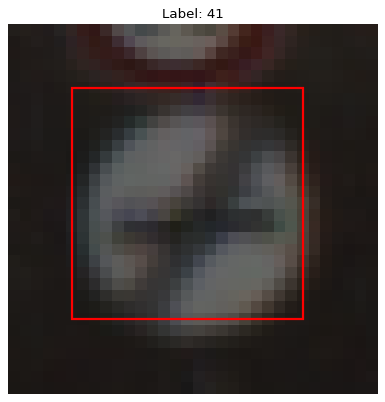

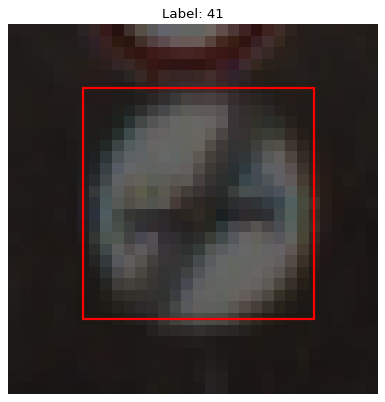

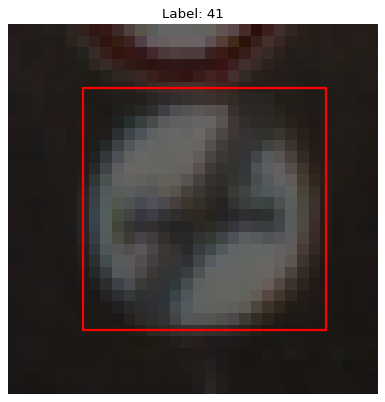

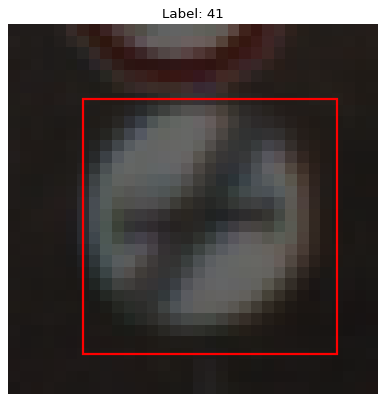

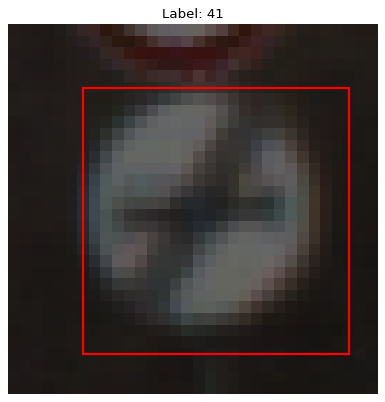

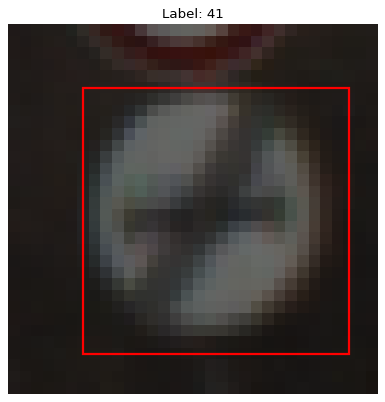

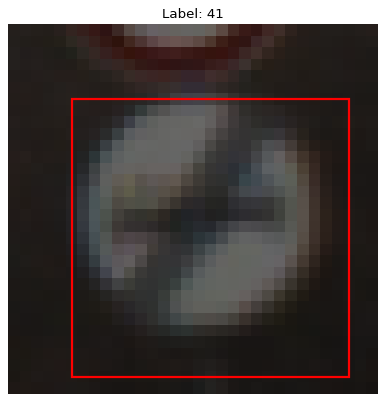

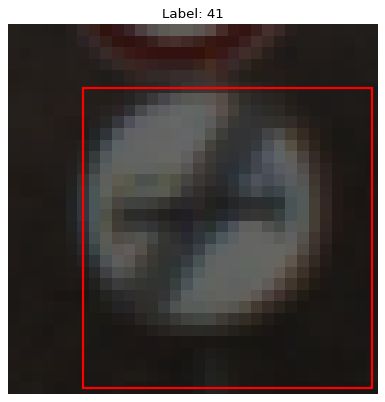

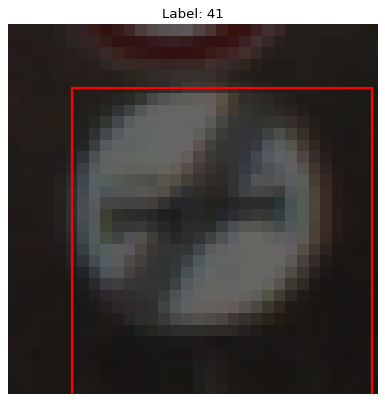

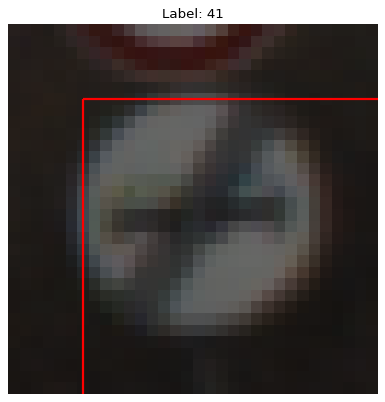

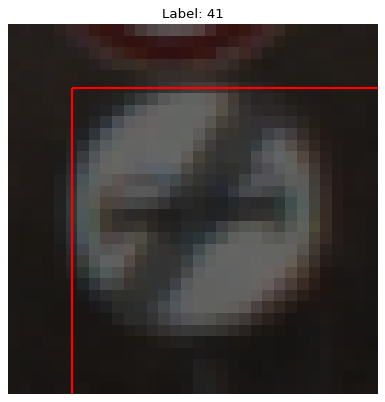

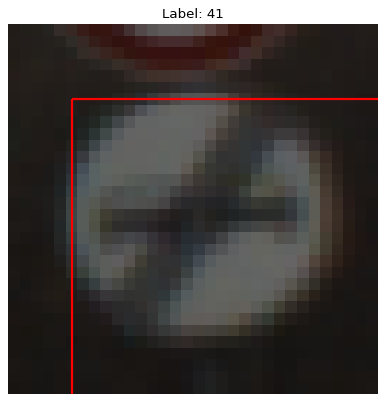

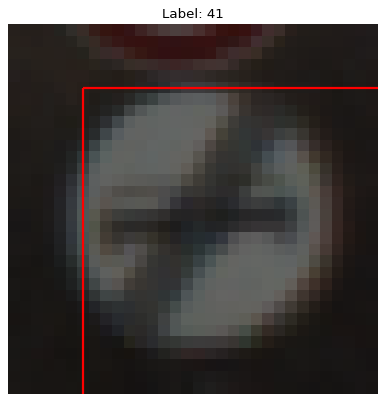

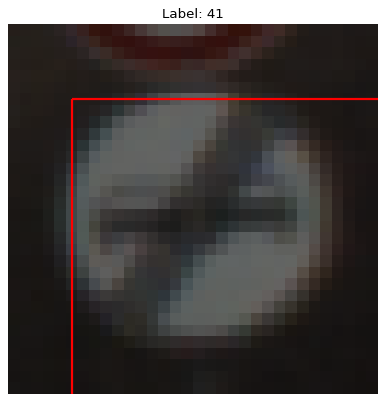

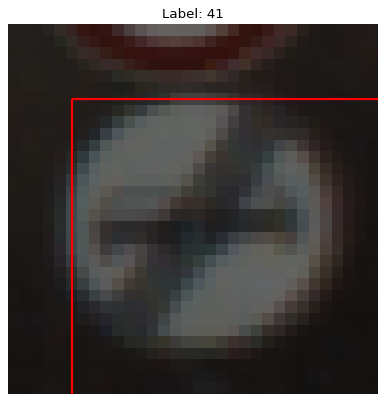

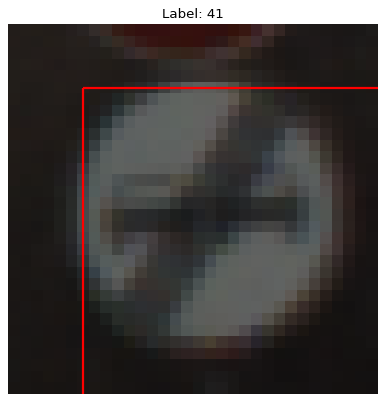

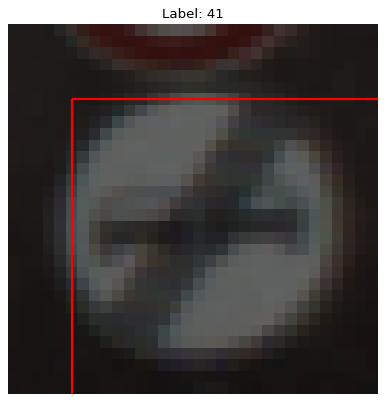

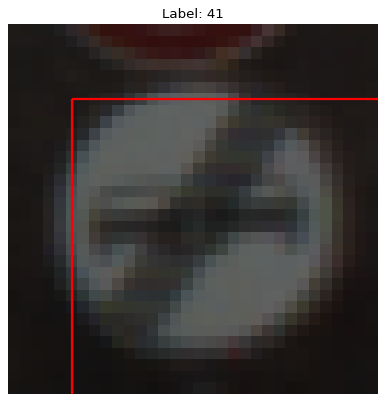

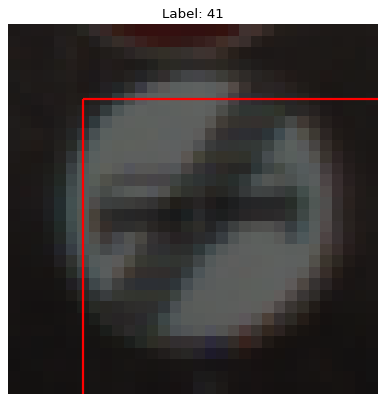

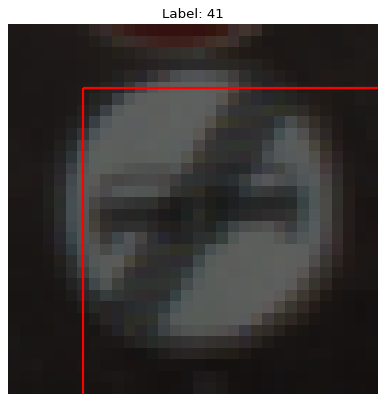

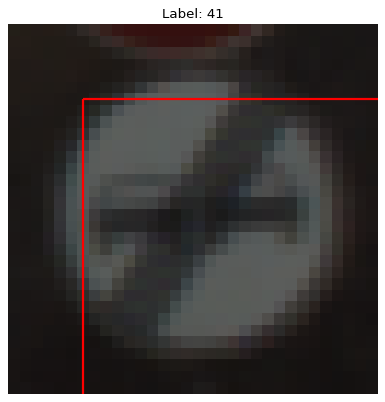

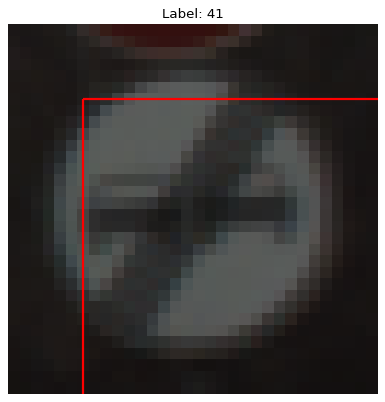

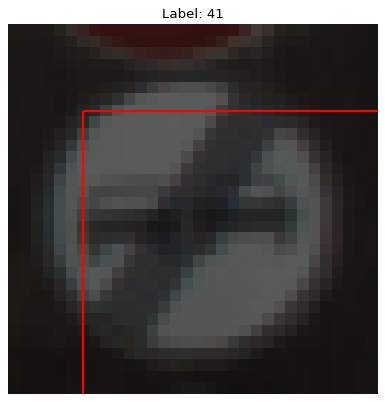

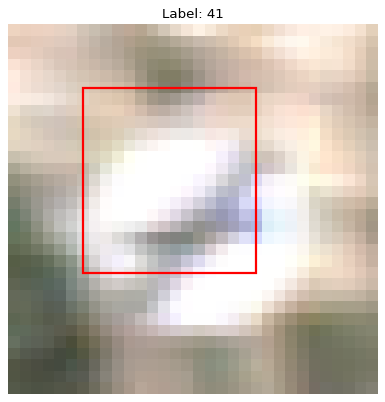

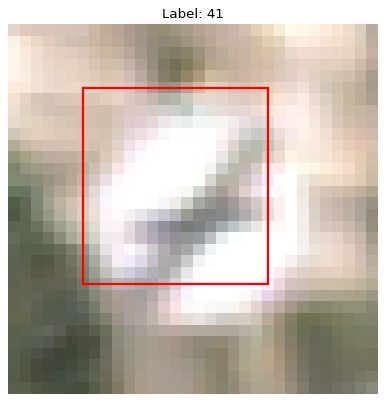

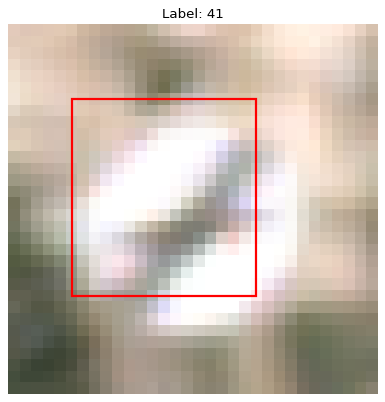

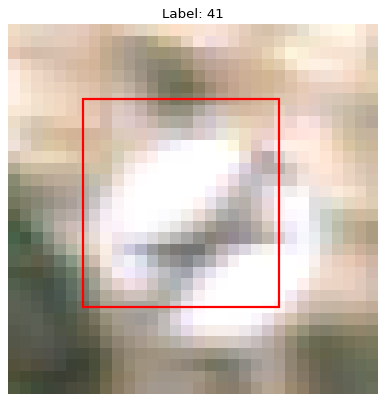

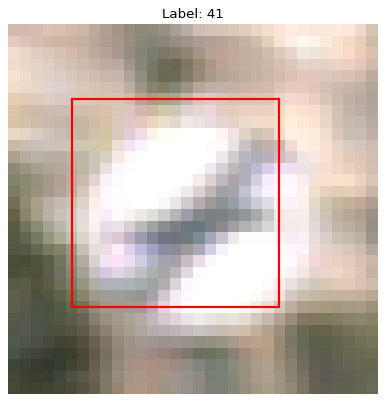

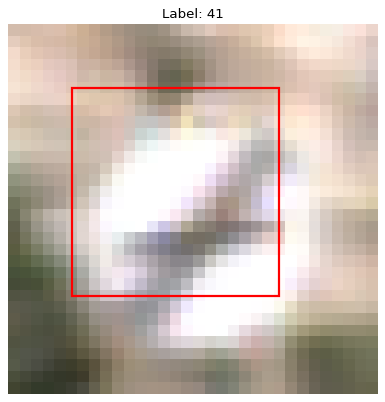

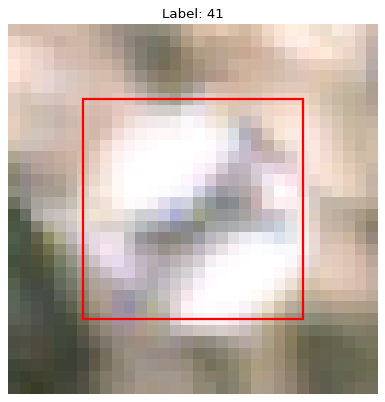

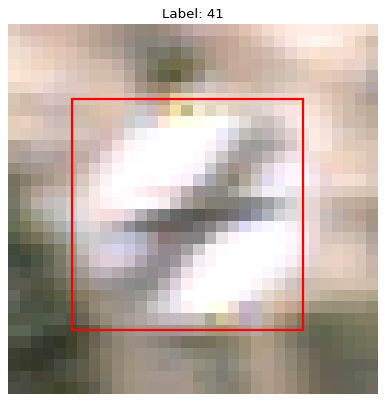

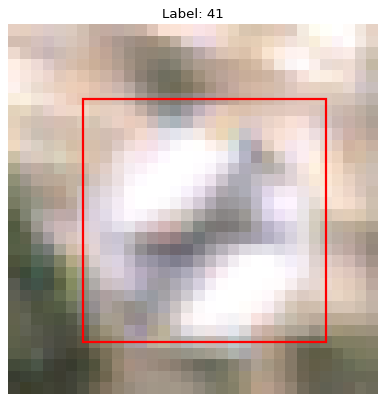

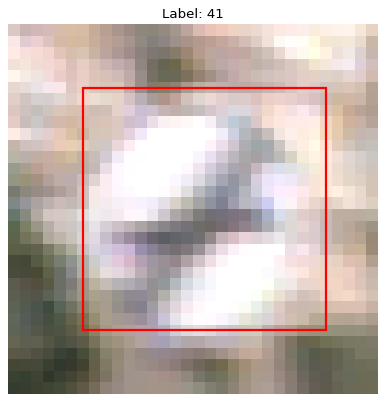

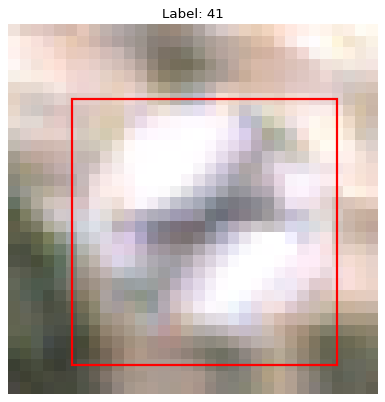

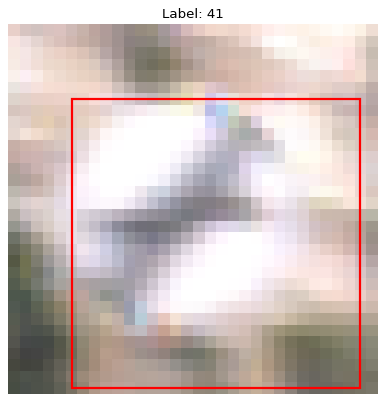

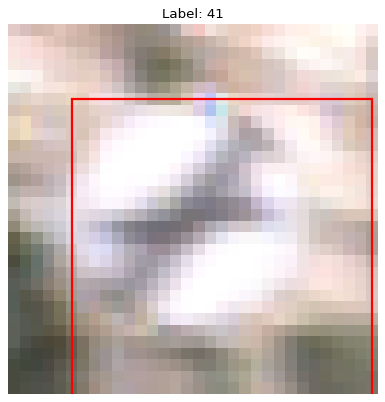

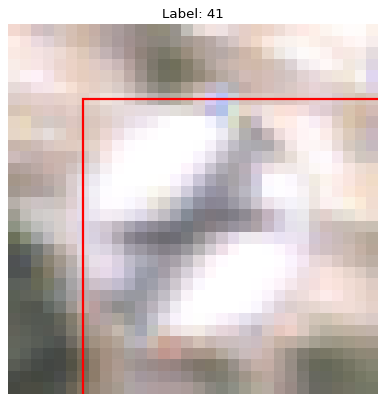

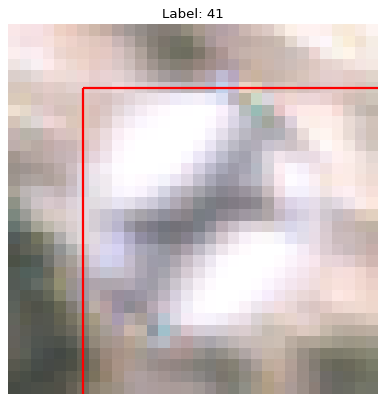

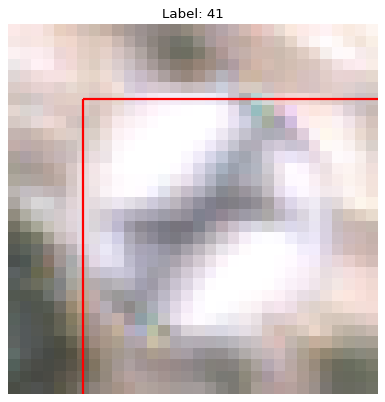

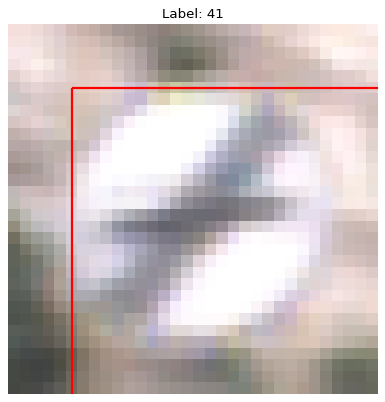

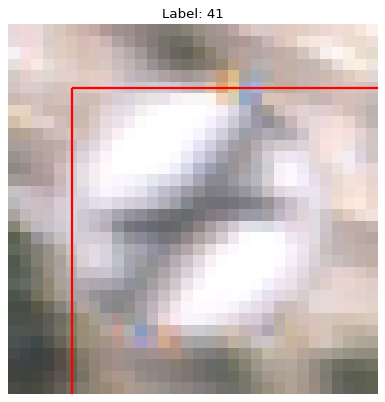

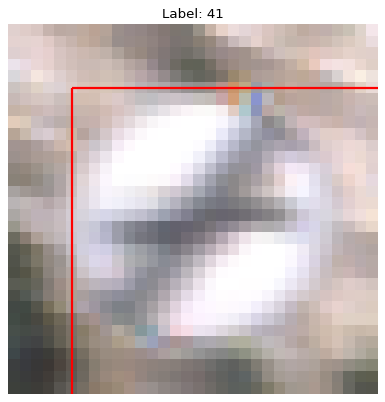

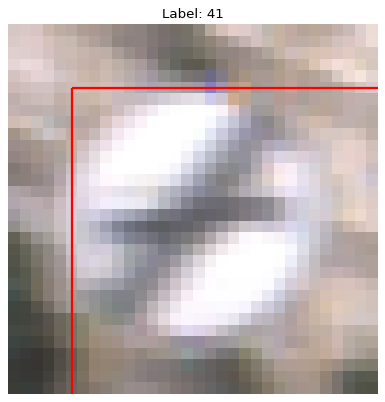

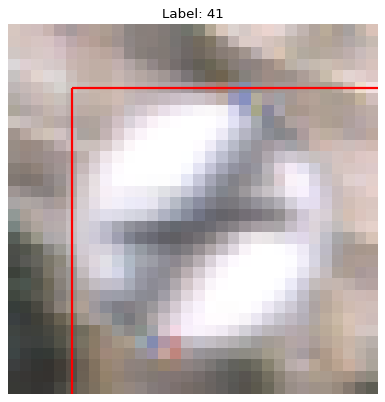

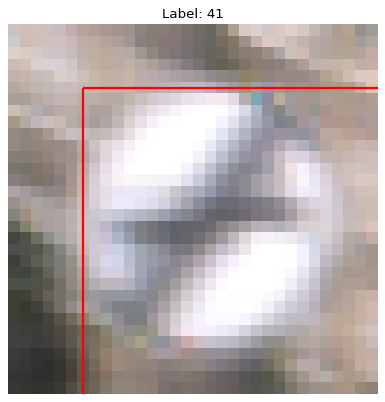

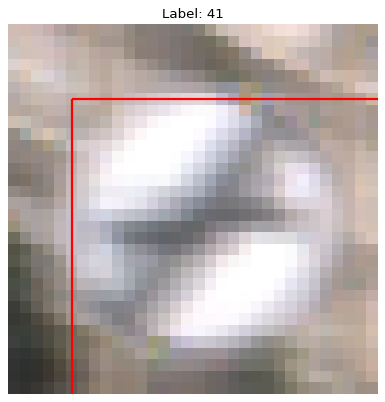

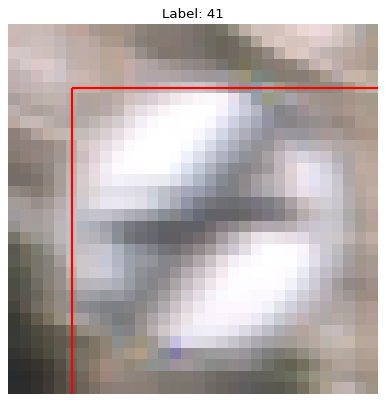

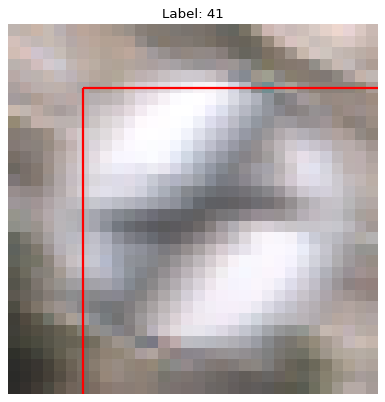

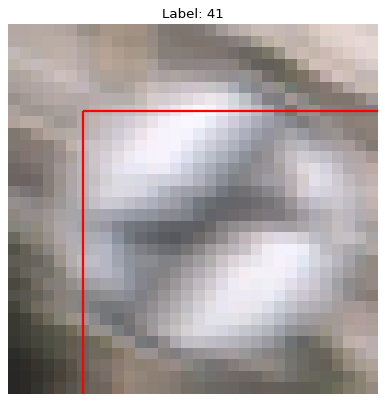

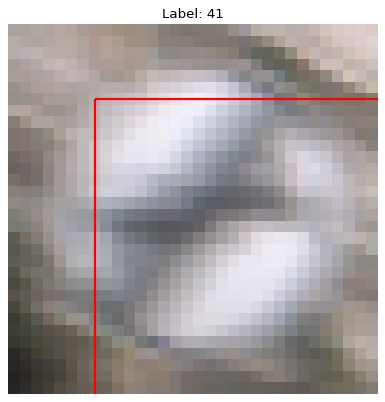

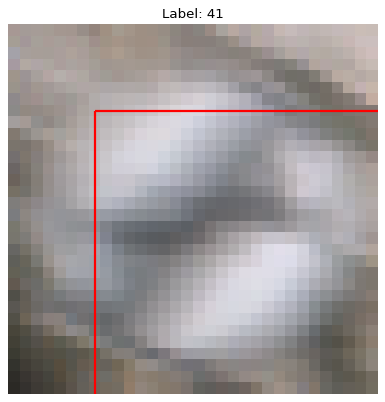

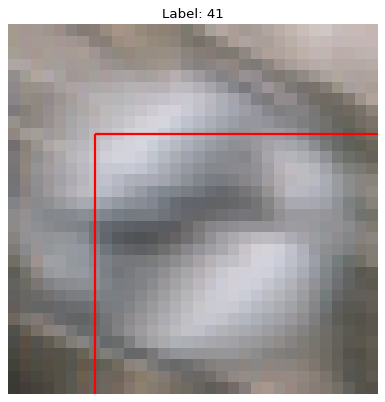

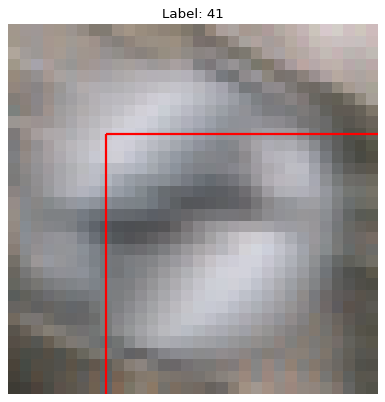

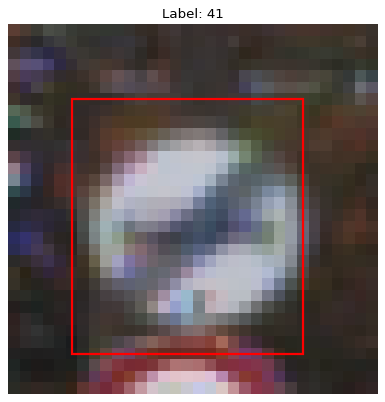

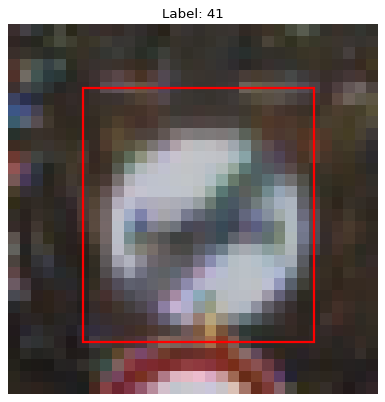

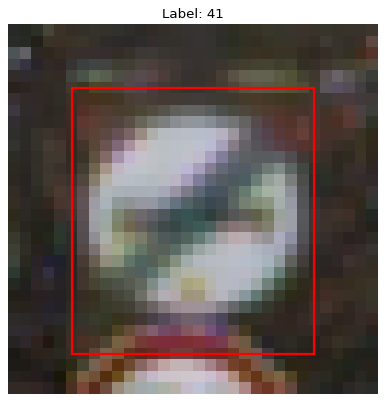

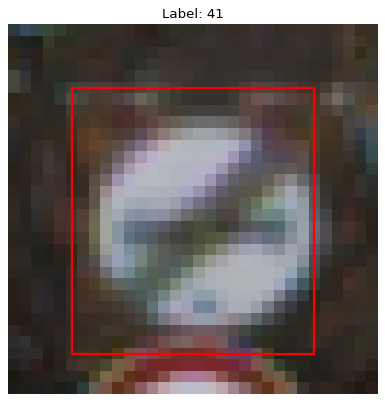

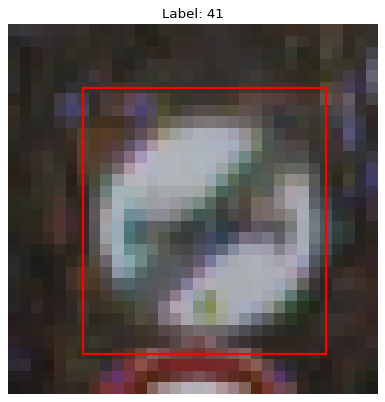

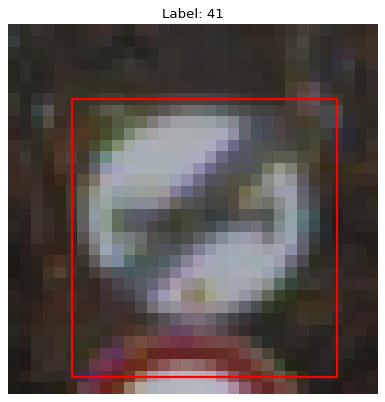

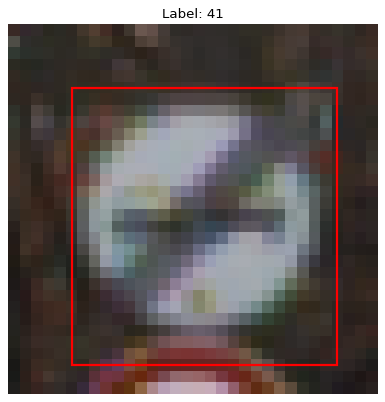

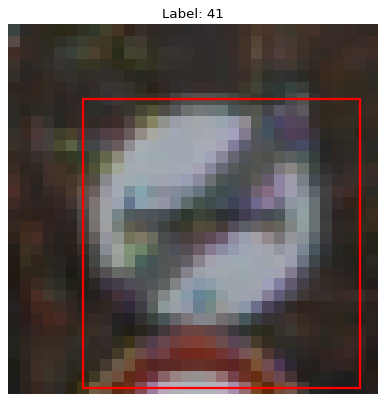

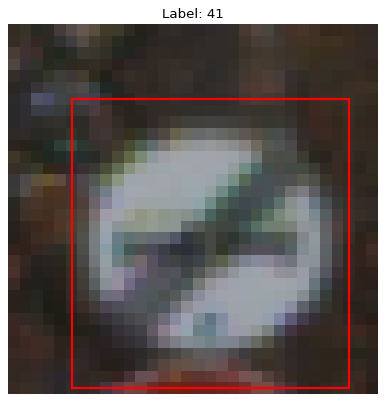

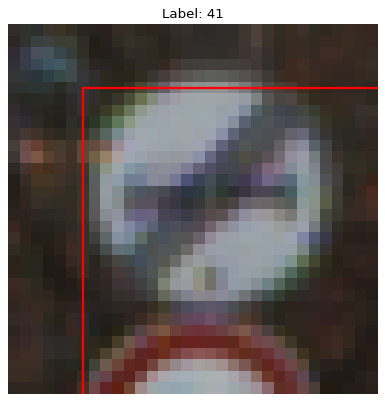

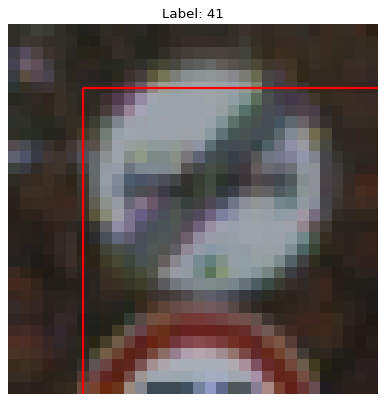

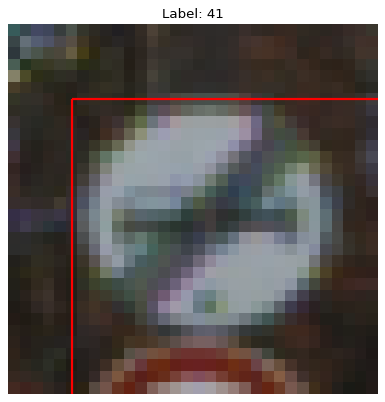

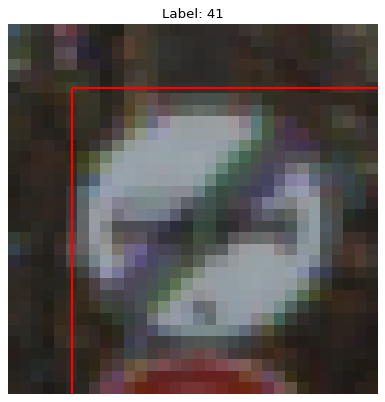

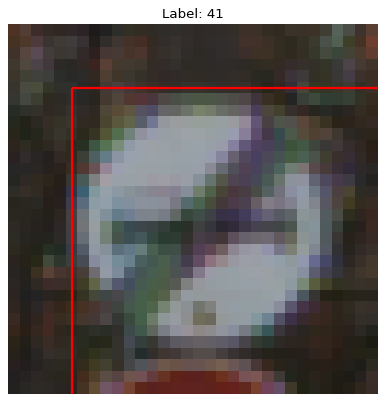

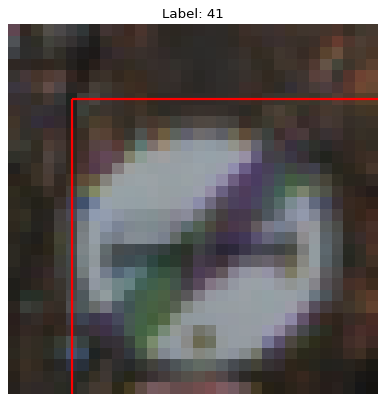

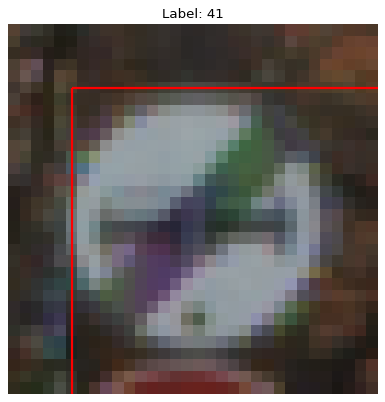

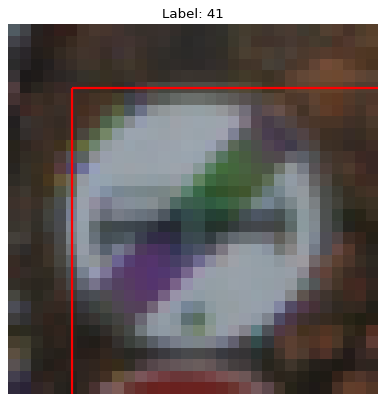

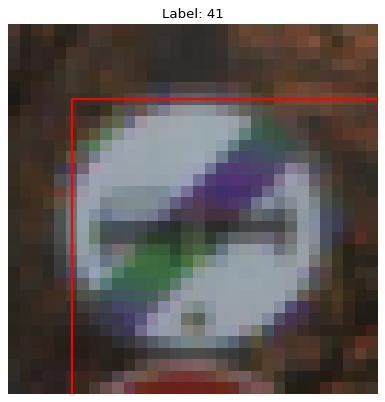

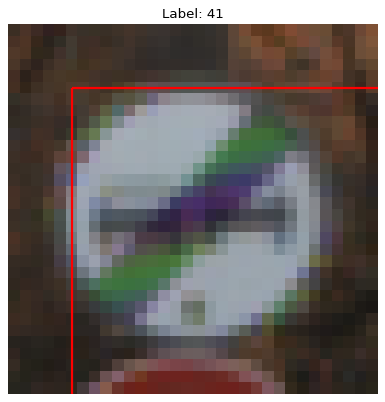

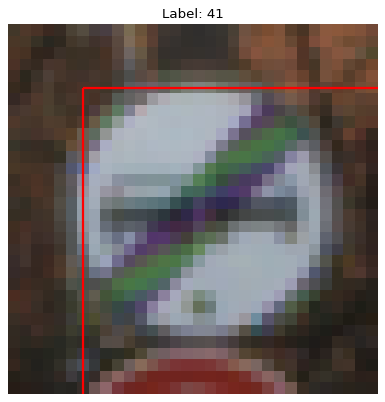

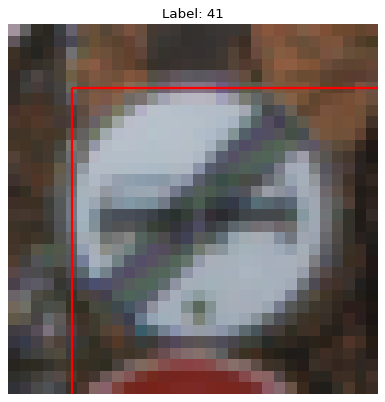

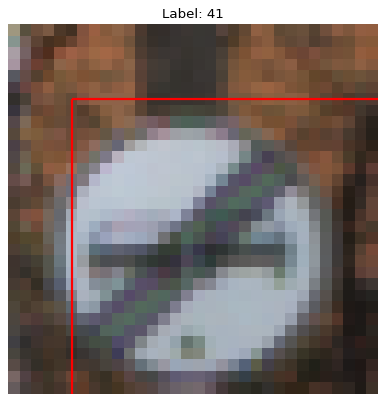

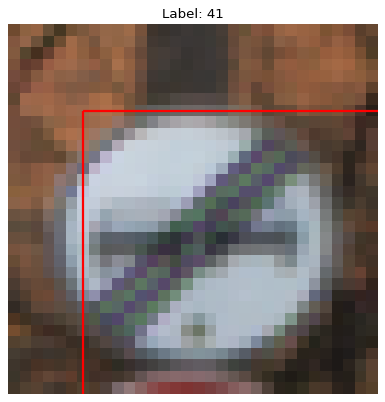

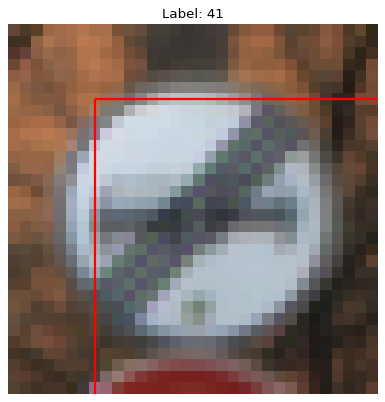

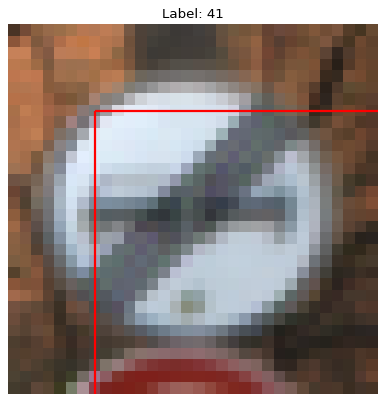

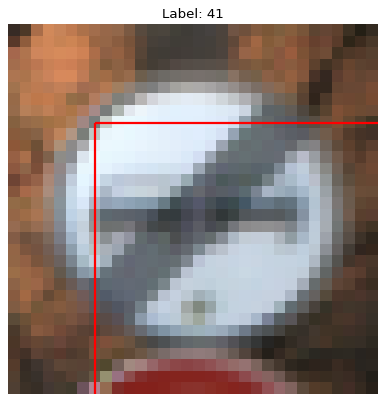

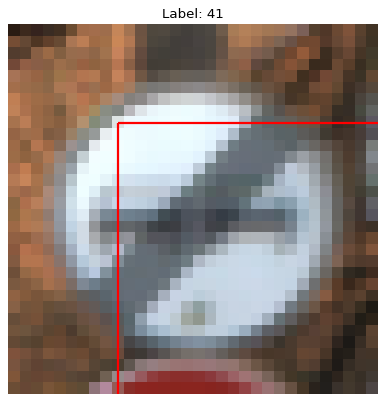

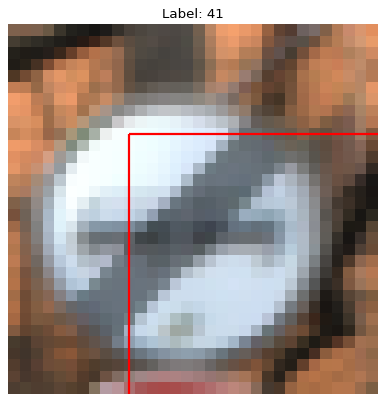

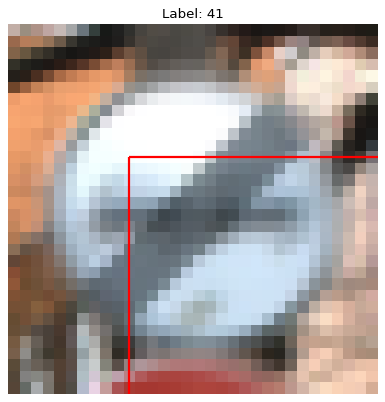

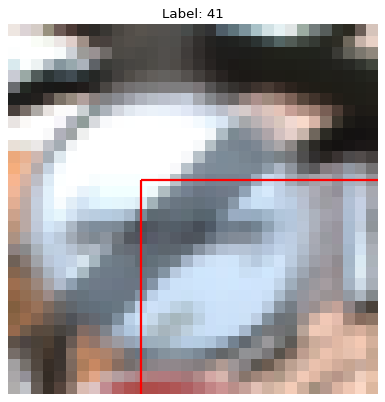

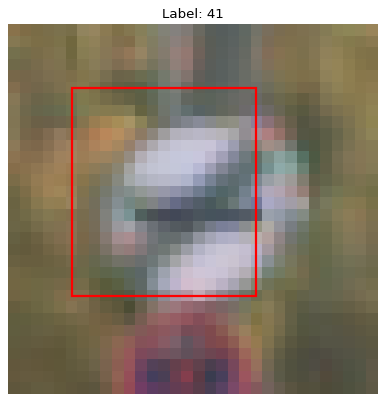

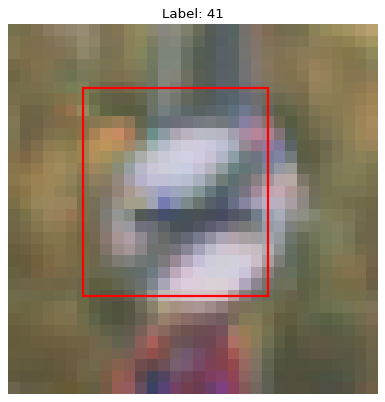

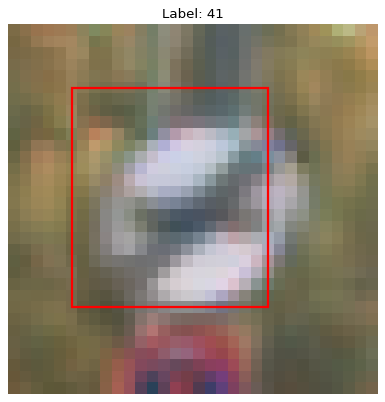

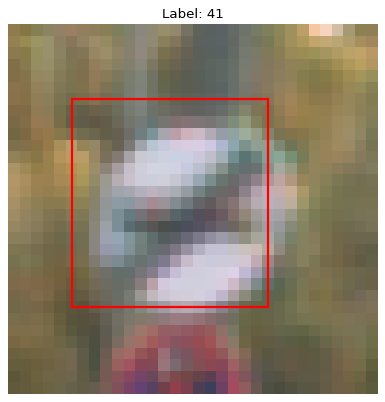

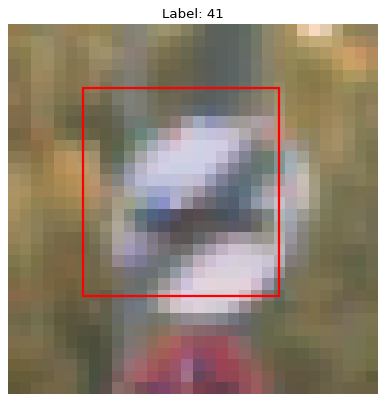

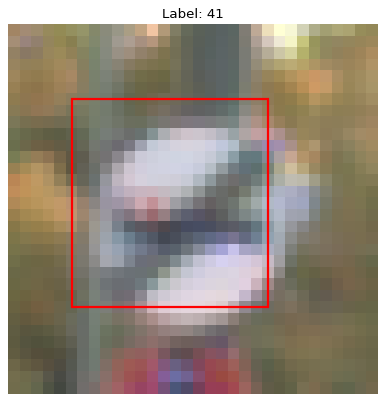

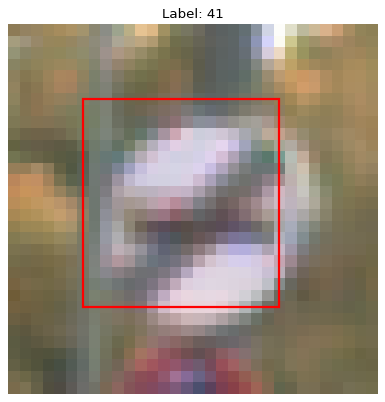

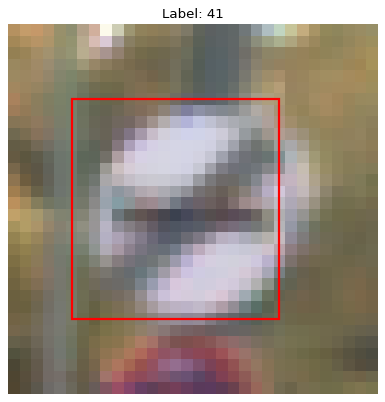

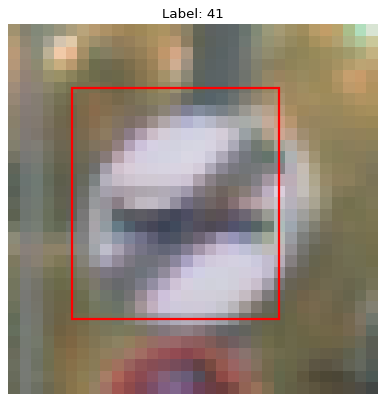

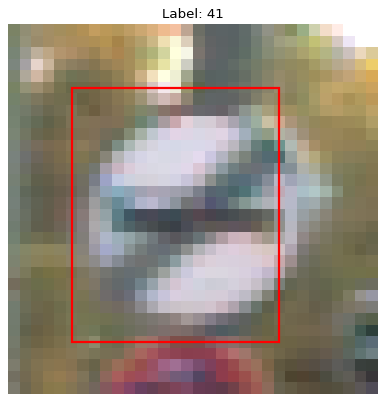

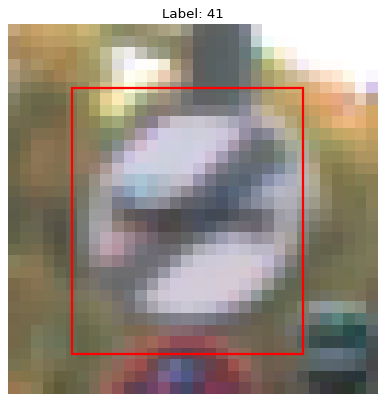

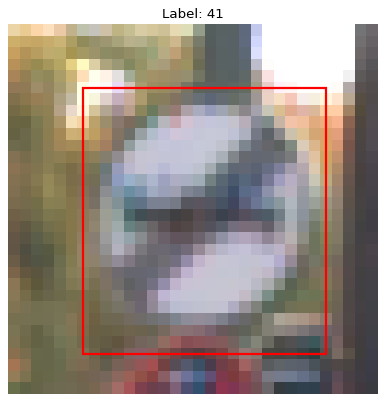

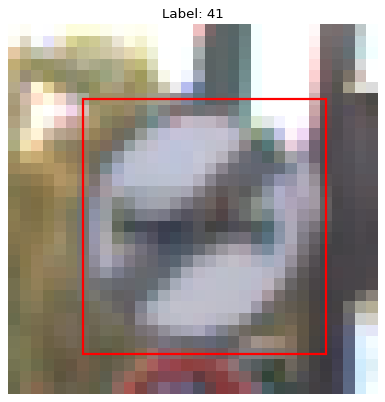

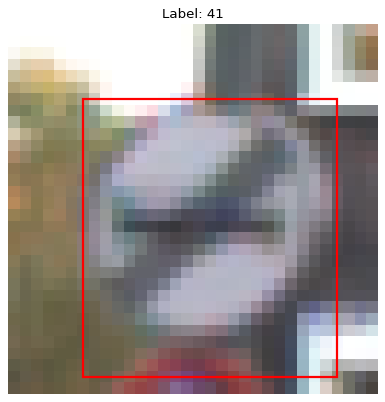

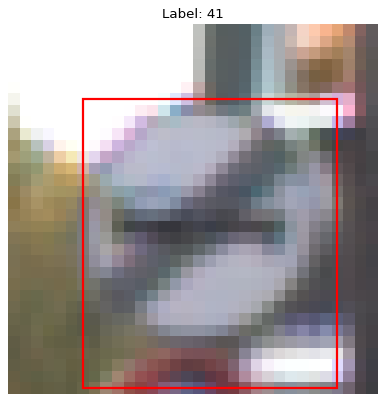

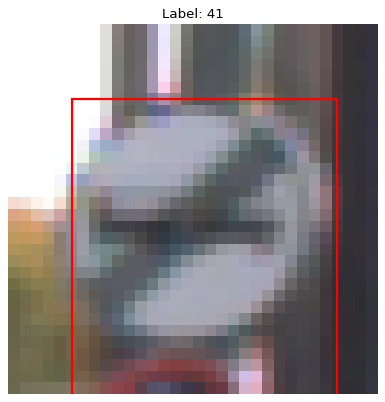

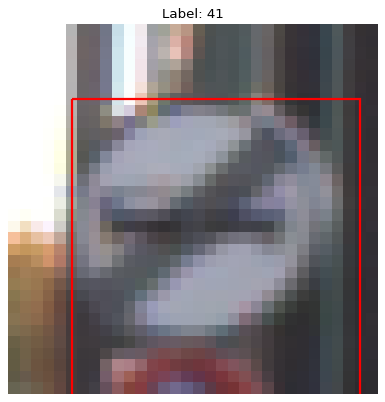

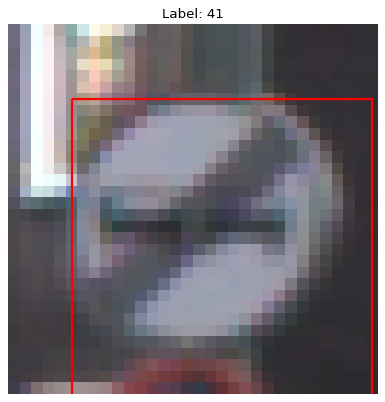

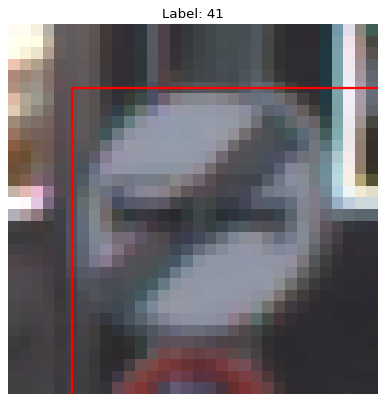

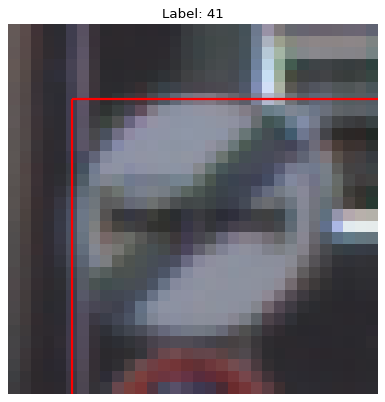

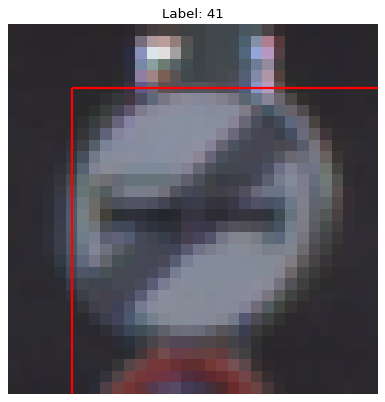

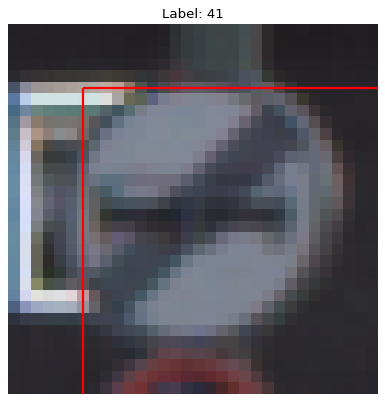

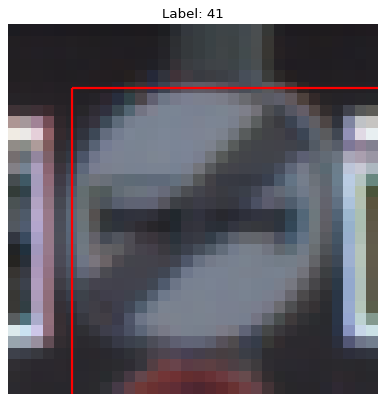

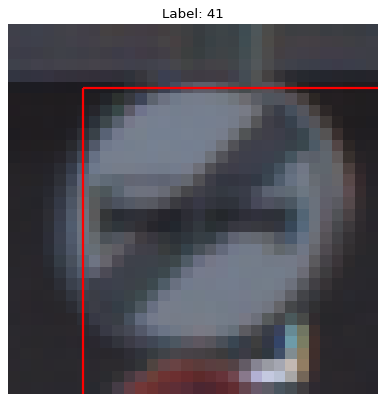

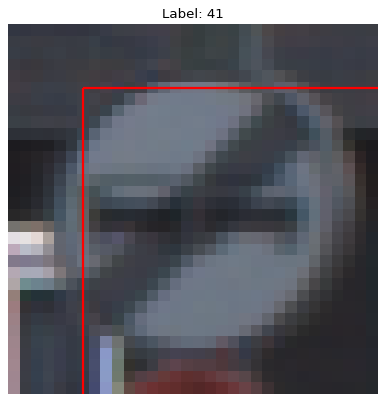

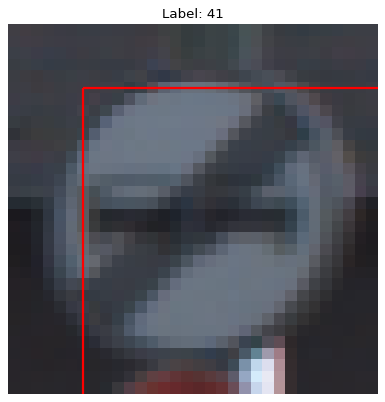

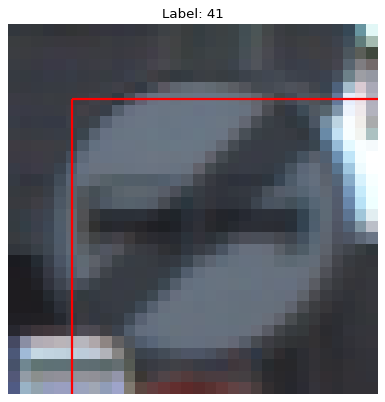

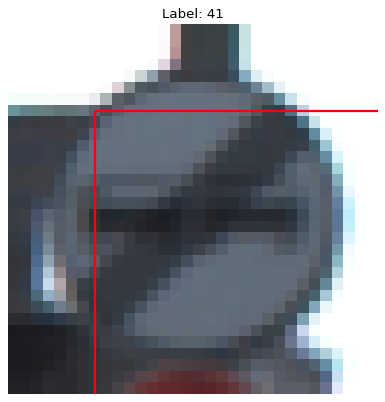

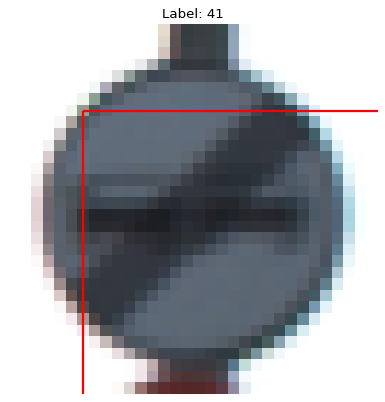

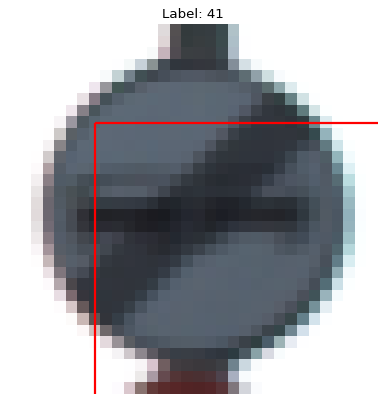

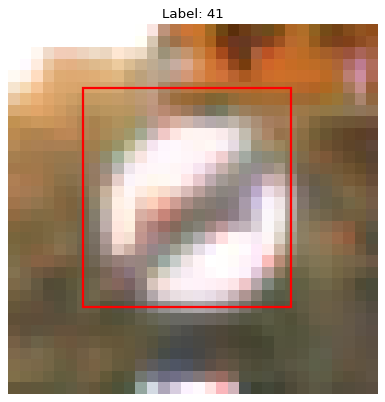

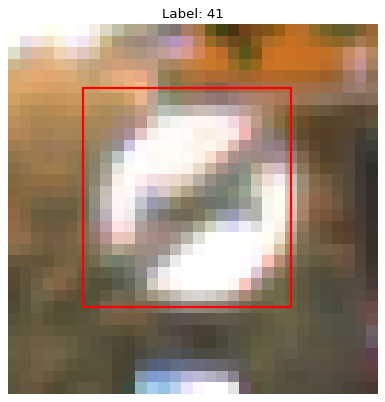

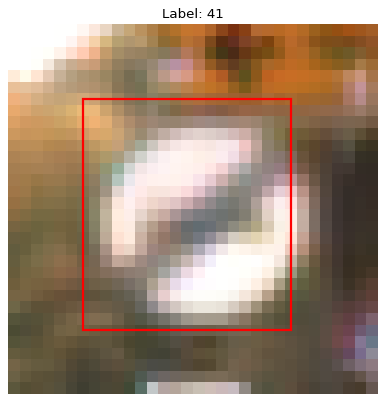

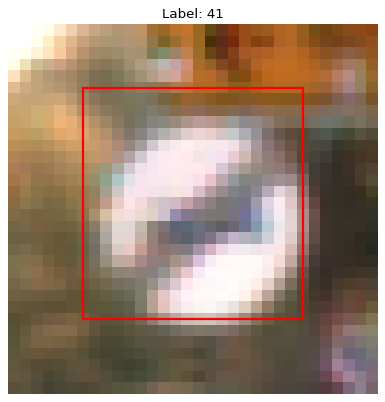

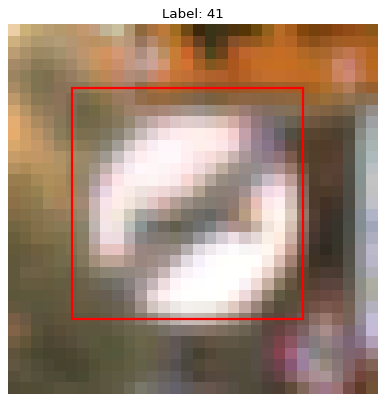

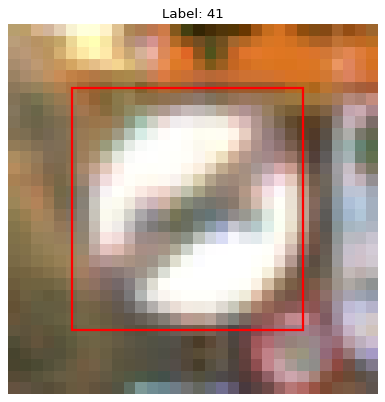

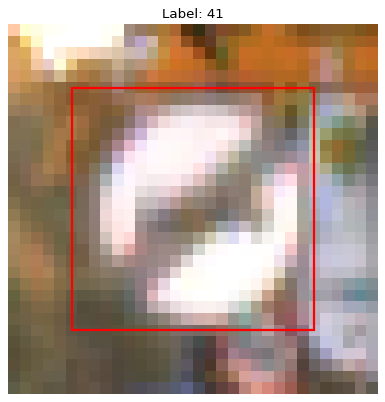

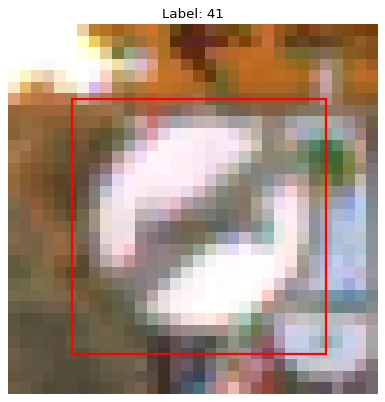

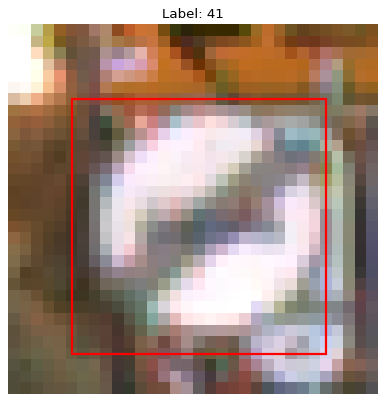

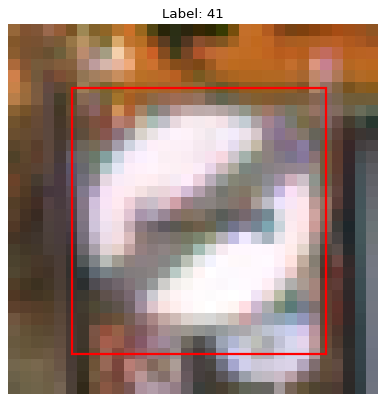

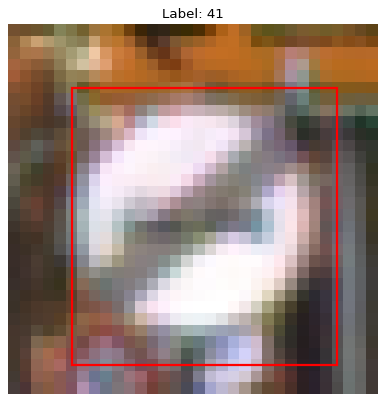

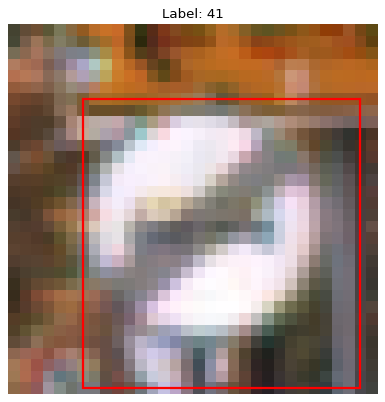

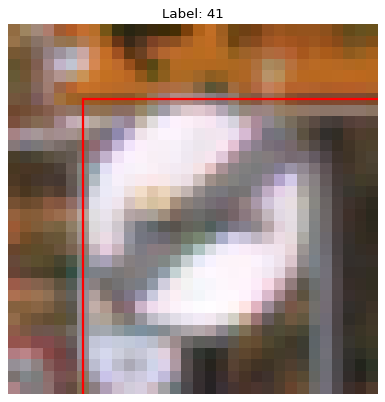

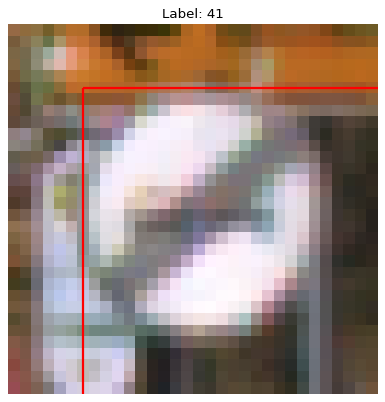

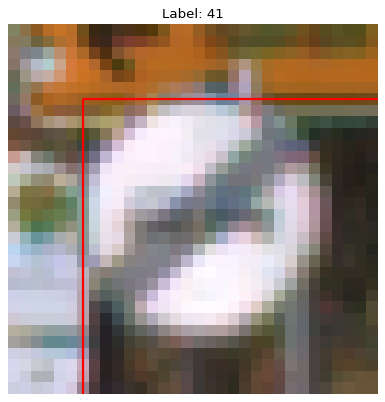

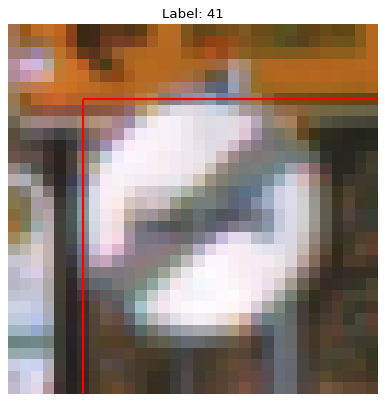

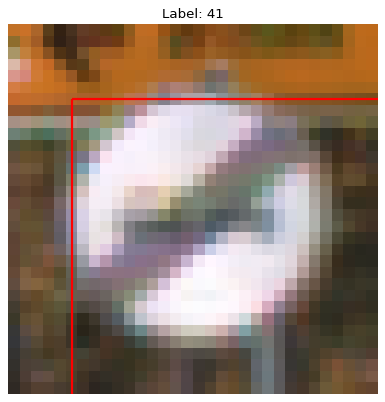

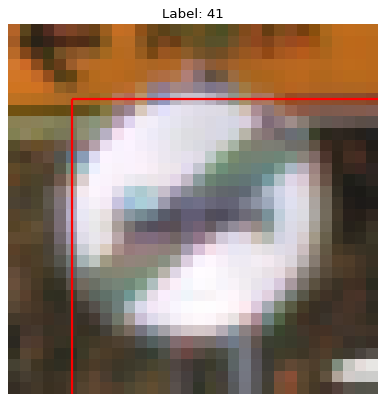

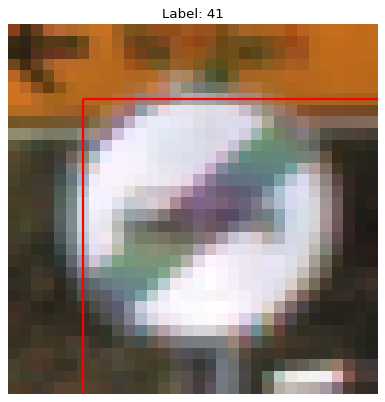

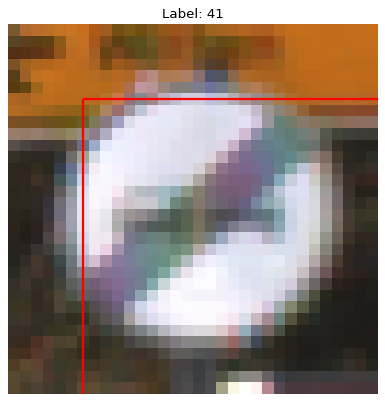

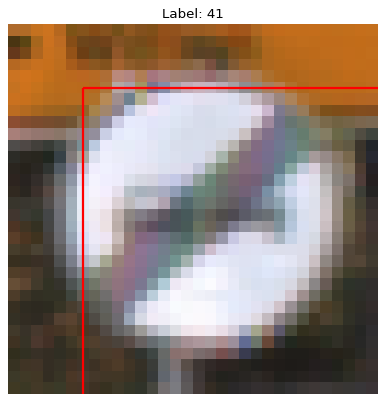

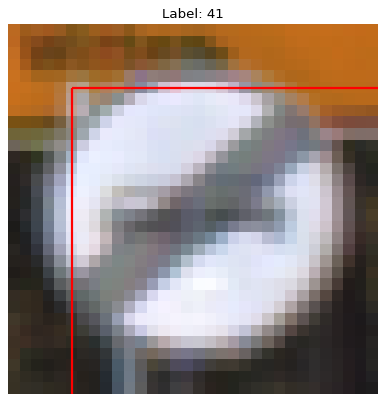

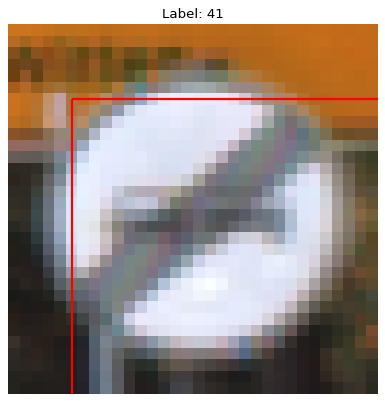

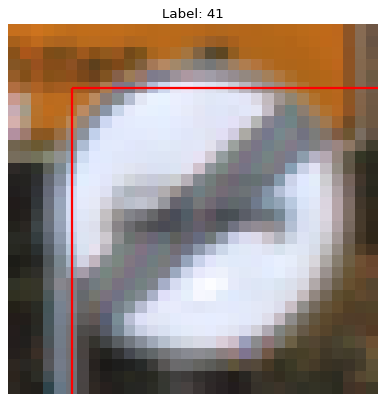

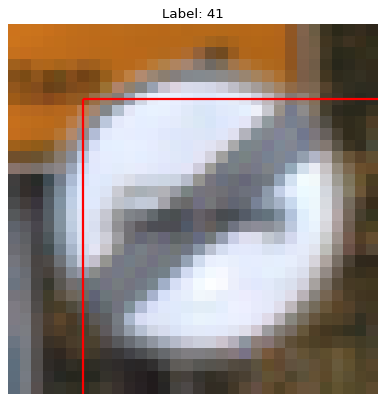

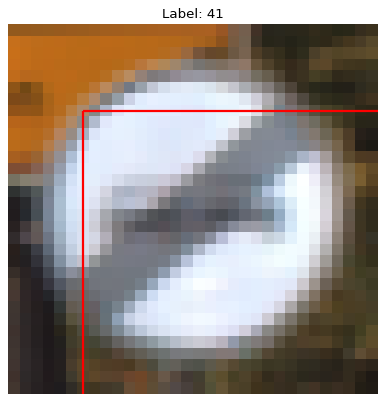

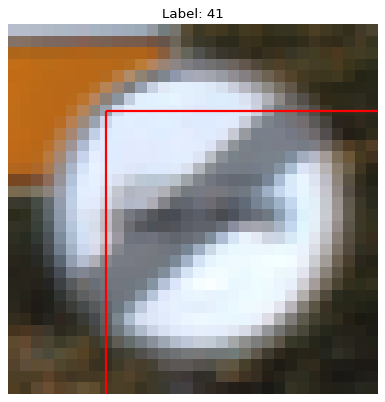

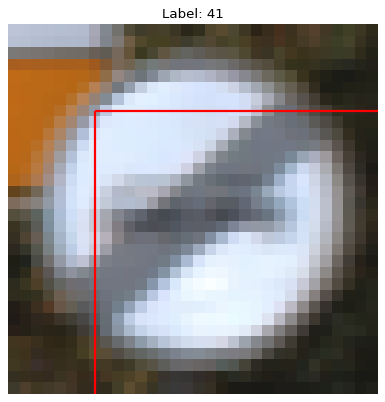

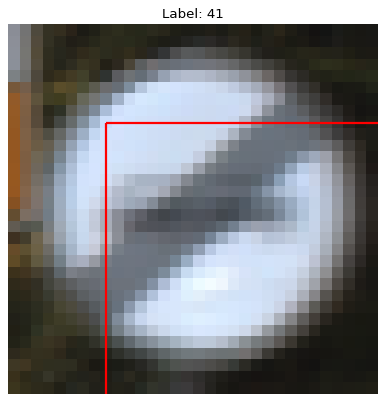

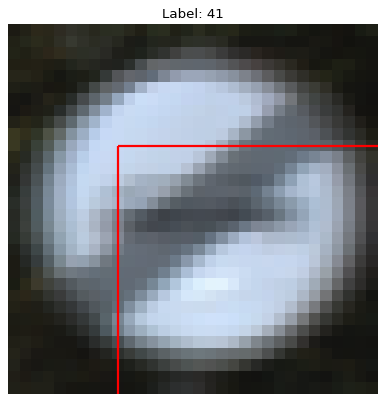

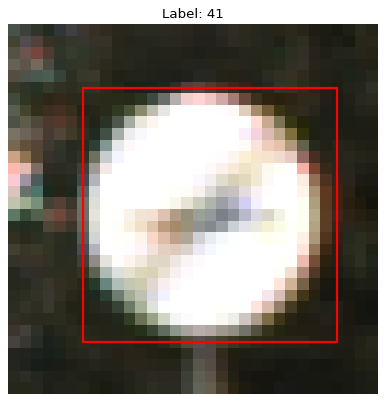

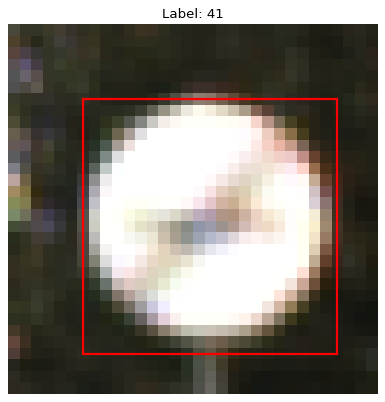

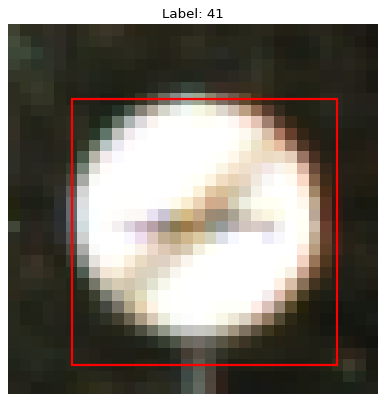

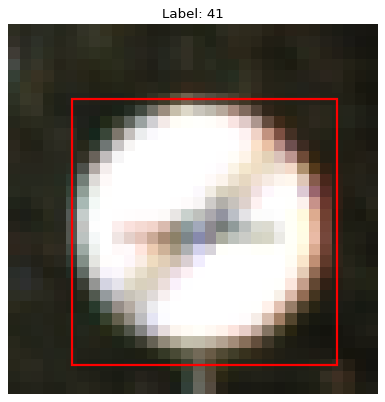

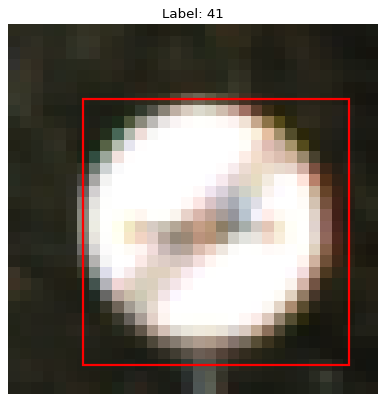

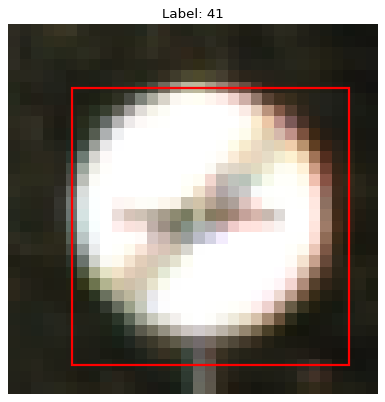

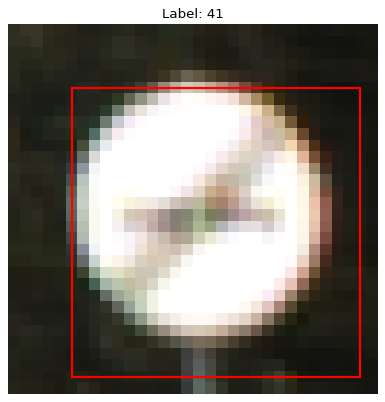

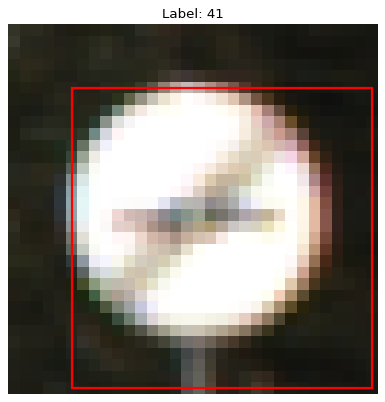

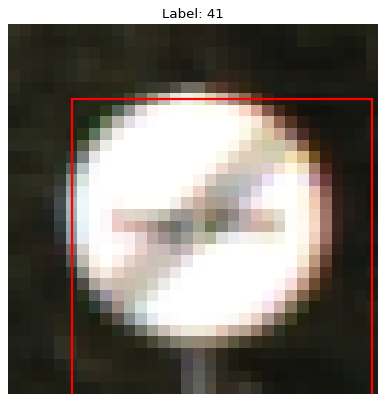

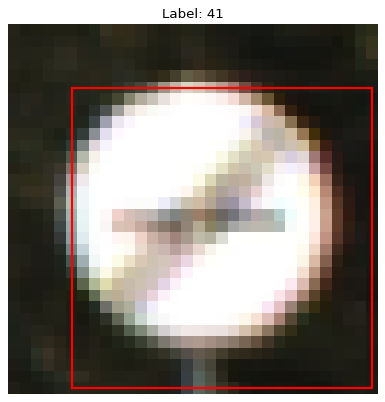

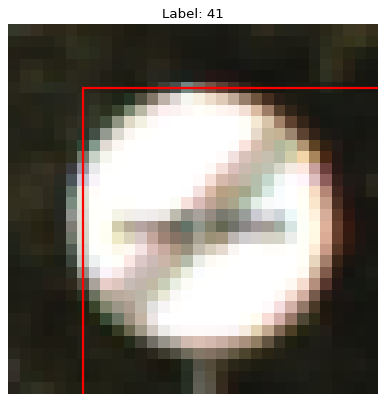

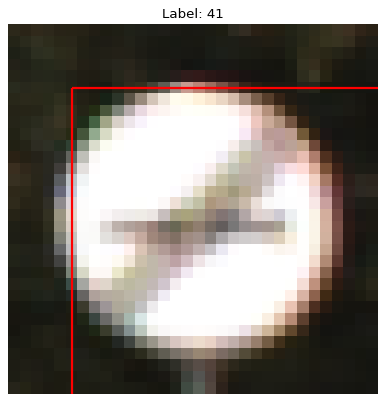

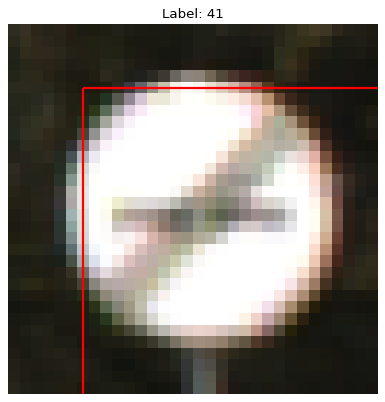

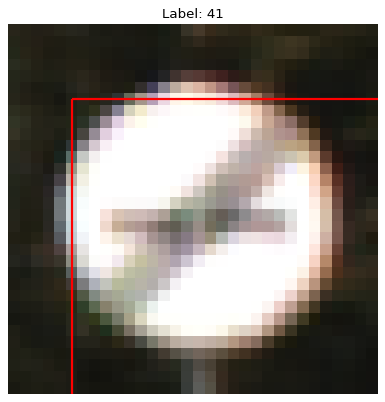

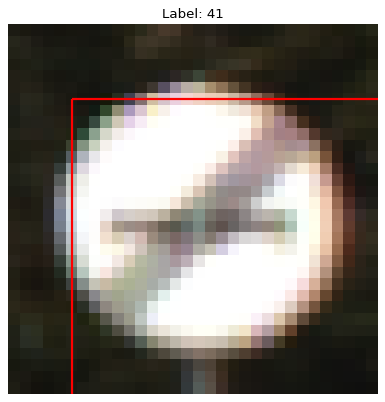

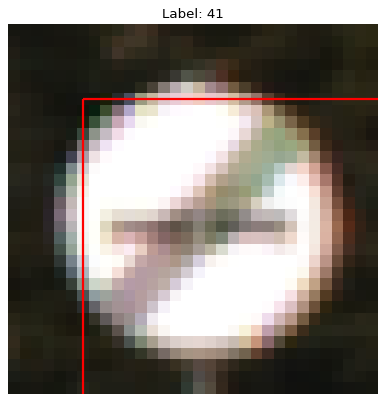

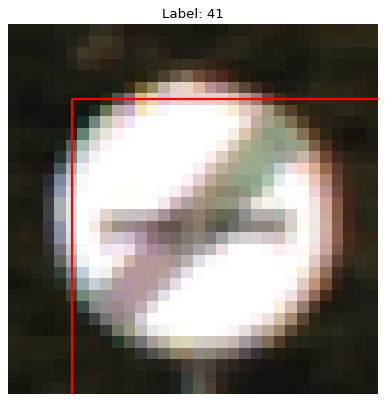

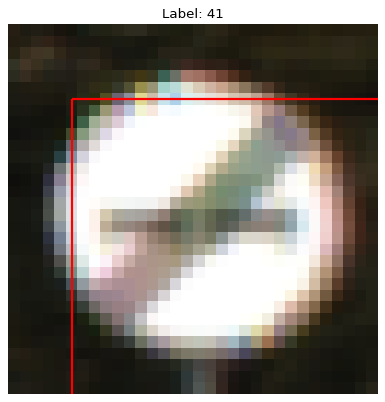

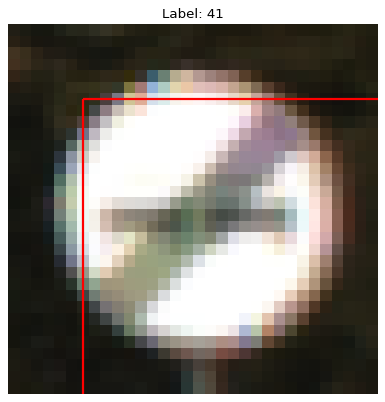

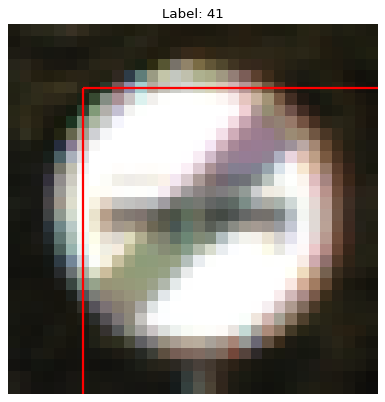

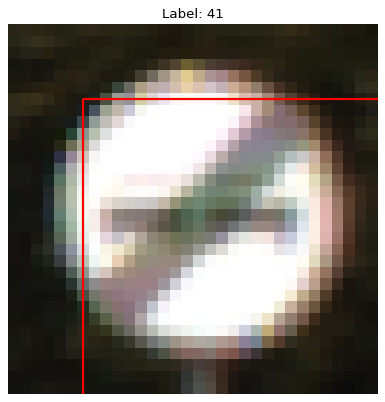

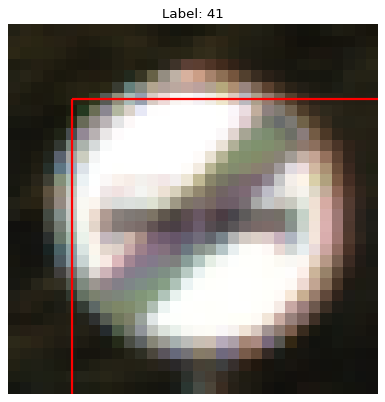

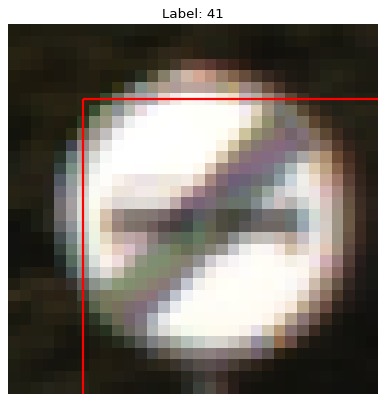

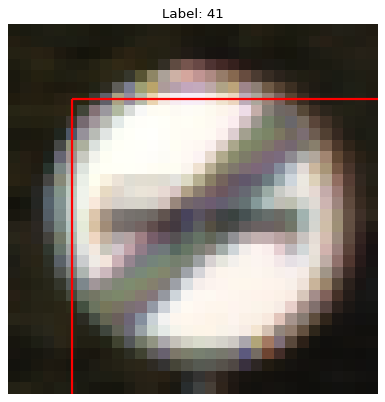

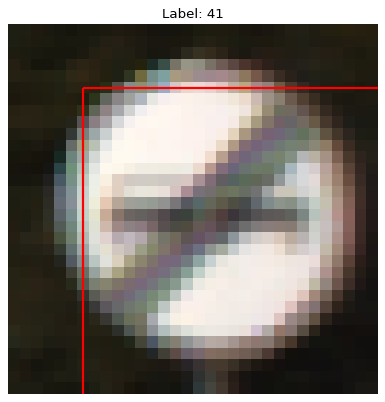

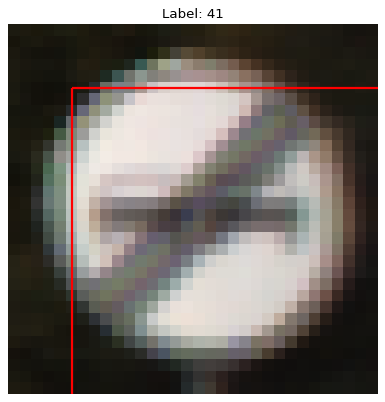

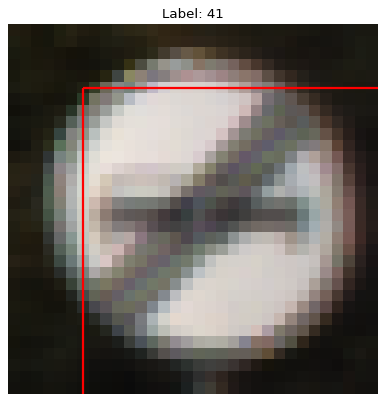

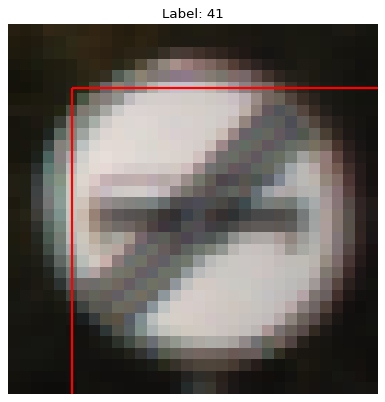

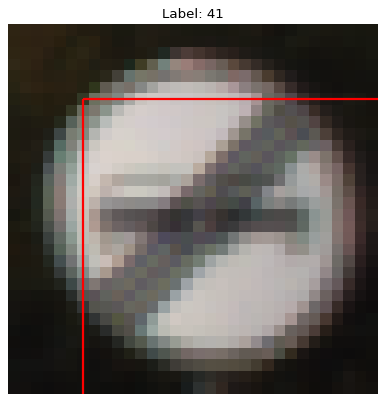

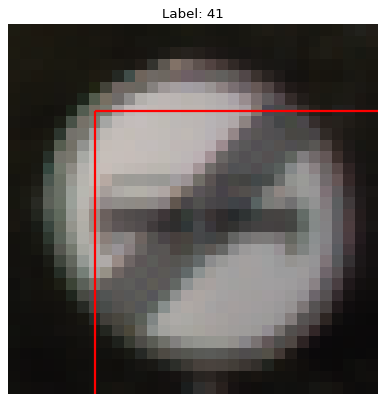

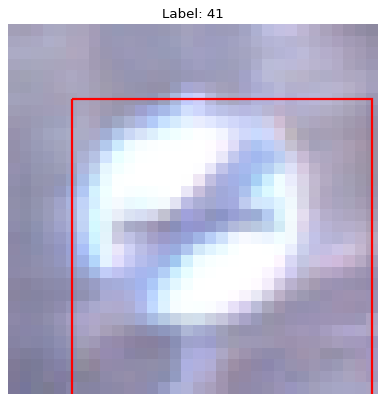

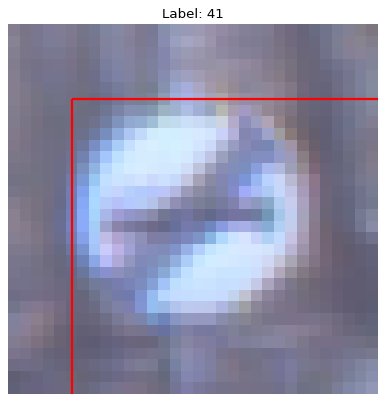

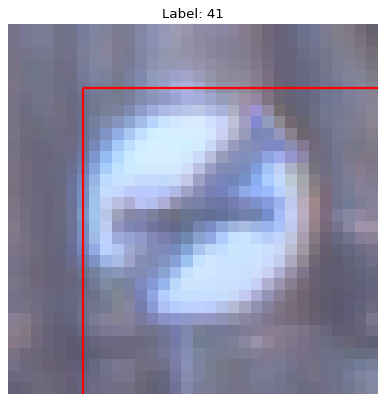

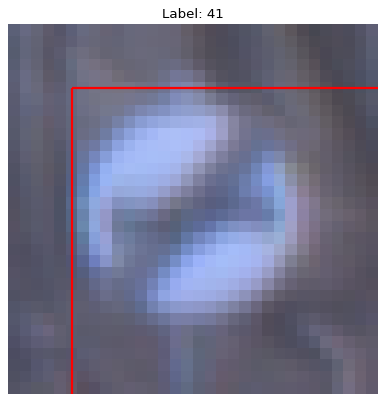

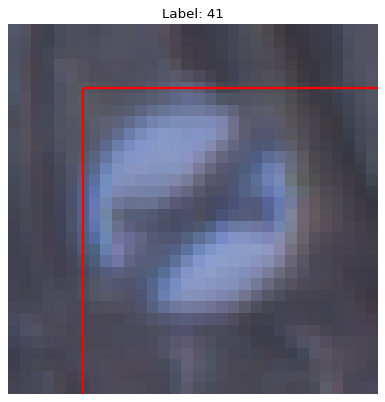

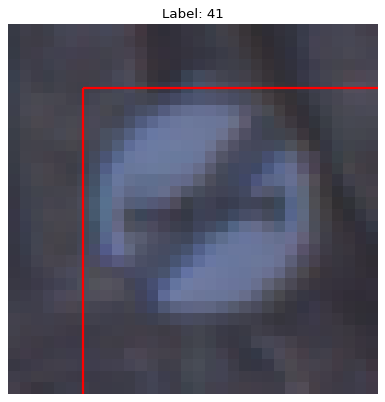

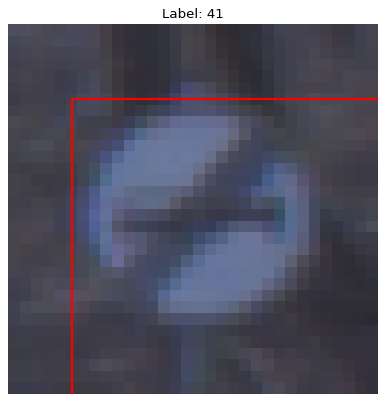

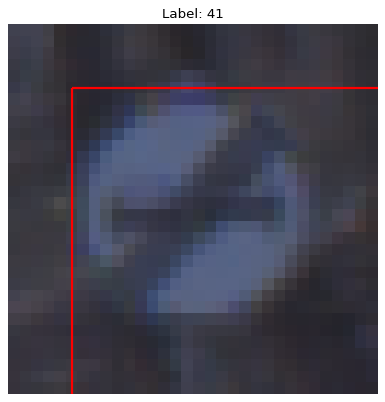

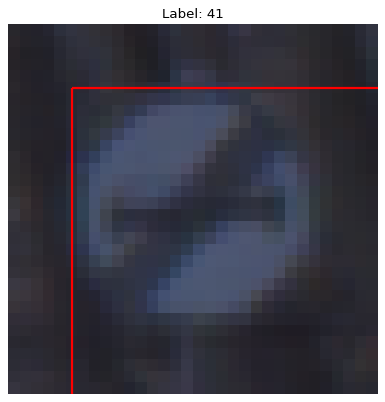

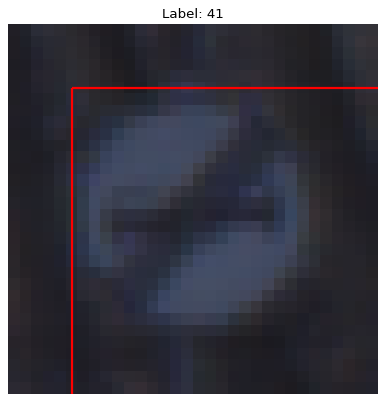

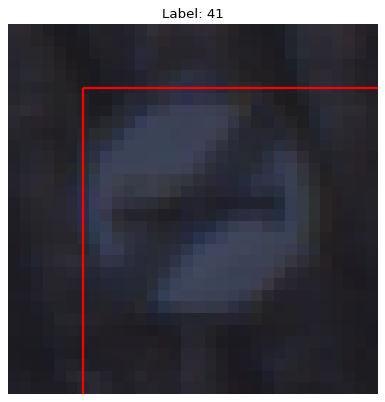

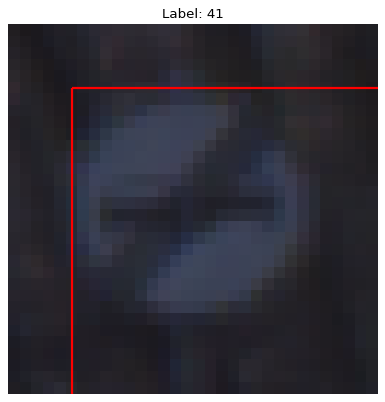

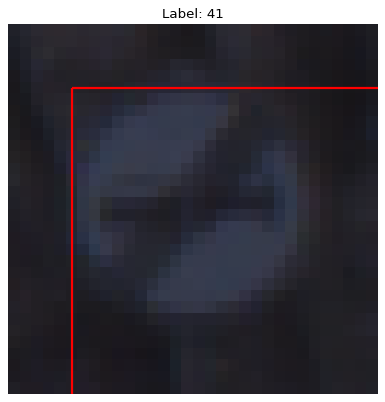

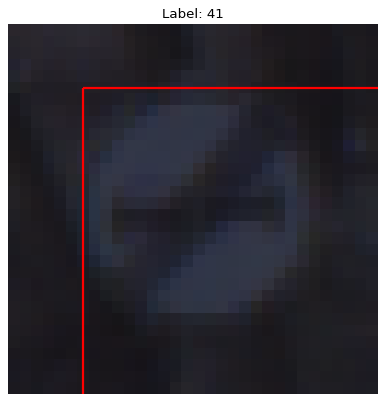

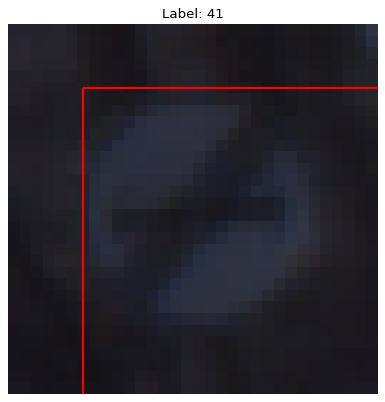

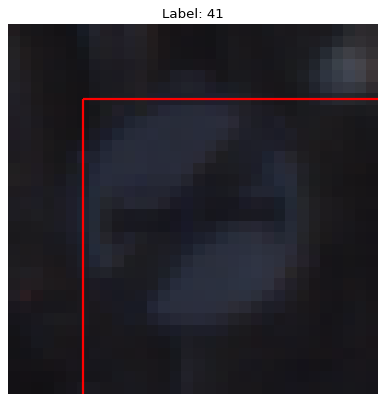

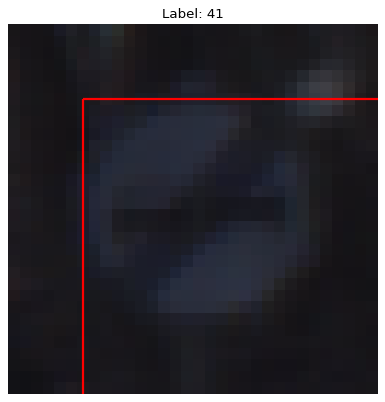

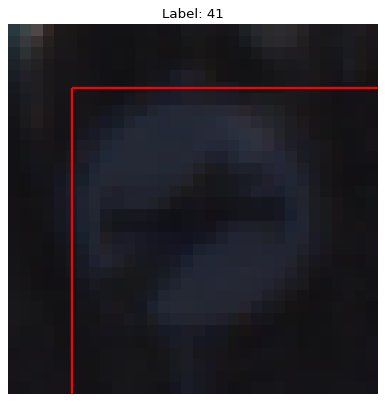

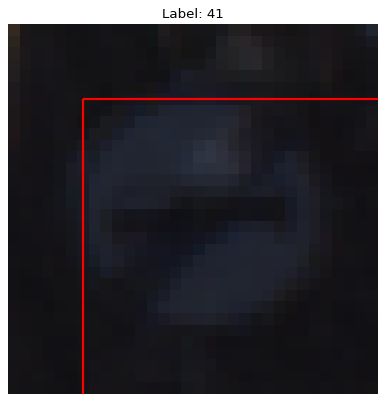

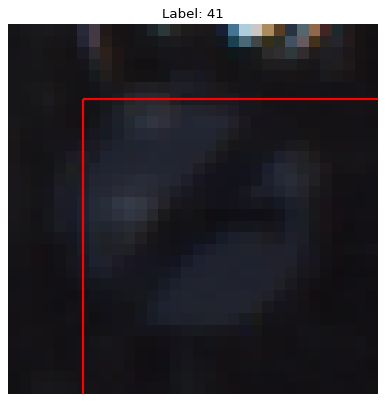

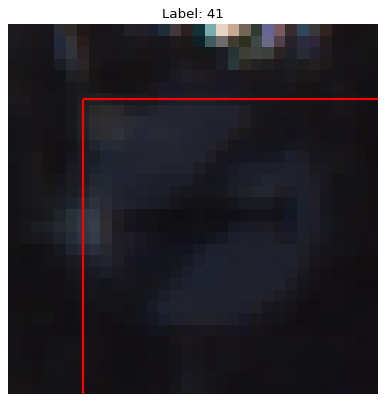

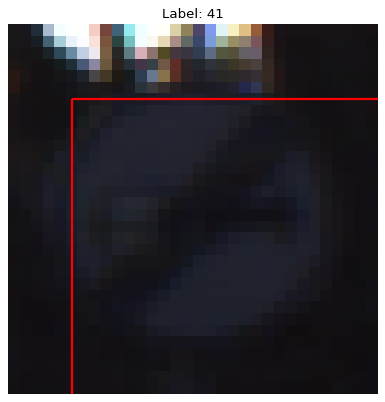

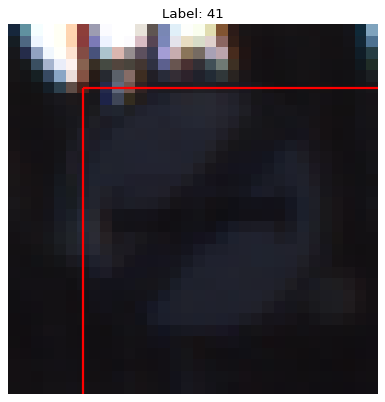

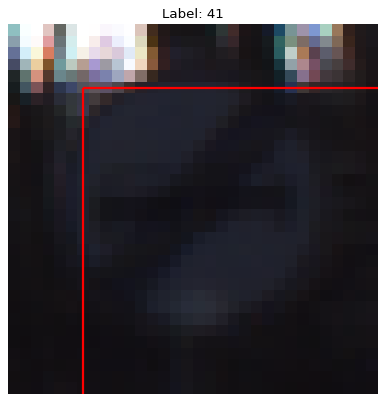

KeyboardInterrupt: 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Loop through the data and display images with coordinates
for index, row in train_df.iterrows():
    image_features = np.array(row['features'])
    coords = row['coords']
    
    # Create a figure and axis with appropriate DPI settings
    fig, ax = plt.subplots(figsize=(6, 6), dpi=80)

    # Display the image
    ax.imshow(image_features)

    # Calculate width and height from the given coordinates
    width = coords[2] - coords[0]
    height = coords[3] - coords[1]

    # Create a rectangle patch to indicate the traffic sign
    rect = patches.Rectangle(
        (coords[0], coords[1]),
        width, height,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

    # Set title and axis labels
    plt.title(f"Label: {row['labels']}")
    plt.axis('off')

    plt.show()


2. Dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba.

3. Realizar preprocesamiento de las imágenes, como redimensionarlas a un tamaño estándar, normalización, etc